# Time Series Decomposition & Analysis Assignment

In [8]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### Import the monthly sunspots data set into a Pandas dataframe, and convert the Month field to a datetime data type.

In [3]:
df = pd.read_csv("https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%203/monthly-sunspots.csv")
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [5]:
df.shape

(2820, 2)

In [7]:
df.Month = pd.to_datetime(df.Month)
df.head()

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0


### Use a line chart to plot the time series.

In [11]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none').update(layout=dict(title=dict(x=0.5)))

    fig.show()

In [12]:
ilinechart(df, "Month", "Sunspots", title="Sunspots every Month since 1749")

### Decompose the time series and add columns for the trend, seasonality, and residuals to the data set.

In [13]:
series = df.set_index("Month")
series.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [23]:
dc = sm.tsa.seasonal_decompose(series, model="additive", freq=252)

In [24]:
trend = dc.trend.reset_index()
seasonality = dc.seasonal.reset_index()
residuals = dc.resid.reset_index()

In [25]:
mrgd = df.merge(trend, on="Month")
mrgd = mrgd.merge(seasonality, on="Month")
mrgd = mrgd.merge(residuals, on="Month")
mrgd.columns = ["Month", "Observed", "Trend", "Seasonality", "Residuals"]
mrgd.head()

,Month,Observed,Trend,Seasonality,Residuals
0,1749-01-01,58.0,NaN,14.405719,NaN
1,1749-02-01,62.6,NaN,15.021334,NaN
2,1749-03-01,70.0,NaN,13.513239,NaN
3,1749-04-01,55.7,NaN,6.423298,NaN
4,1749-05-01,85.0,NaN,12.916790,NaN


### Plot the observed values, trend, seasonality, and residuals on a multi-line chart. You should have a line for each column.

**Hint:** You may need to melt the data so that all the categories are in a single column and all the values are in a single column.

In [26]:
mltd = pd.melt(mrgd,
               id_vars="Month",
               value_vars=["Observed", "Trend", "Seasonality", "Residuals"],
               var_name="Variable",
               value_name="Value")
mltd.head()

,Month,Variable,Value
0,1749-01-01,Observed,58.0
1,1749-02-01,Observed,62.6
2,1749-03-01,Observed,70.0
3,1749-04-01,Observed,55.7
4,1749-05-01,Observed,85.0


### Add two columns to the data set - one that calculates a rolling mean and another that calculates a rolling standard deviation.

In [27]:
ilinechart(mltd, "Month", "Value", groups="Variable", title="Observed vs Components")

### Plot the rolling mean and standard deviation on a multi-line chart along with the observed values.

In [30]:
mrgd["Rolling_Mean"] = mrgd.Observed.rolling(window=252).mean()
mrgd["Rolling_Std"] = mrgd.Observed.rolling(window=252).std()

In [32]:
mltd = pd.melt(
    mrgd,
    id_vars="Month",
    value_vars=["Observed", "Rolling_Mean", "Rolling_Std"],
    var_name="Variable",
    value_name="Value"
)

ilinechart(mltd, "Month", "Value", groups="Variable", title="Rolling Mean & Standard Deviation")

### Perform an Augmented Dickey Fuller Test on the data set and determine whether this time series is stationary.

In [33]:
adf_test = sm.tsa.stattools.adfuller(mrgd.Observed)

adf_test

(-9.567667511913076,
 2.333452143866306e-16,
 27,
 2792,
 {'1%': -3.432694313168895,
  '10%': -2.5673213632123297,
  '5%': -2.862575752726396},
 23141.276837258665)

In [34]:
results = pd.Series(
    adf_test[0:4],
    index=["ADF Test Statistic",
           "P-Value",
           "# of Lags Used",
           "# of Observations Used"]
)

results

ADF Test Statistic       -9.567668e+00
P-Value                   2.333452e-16
# of Lags Used            2.700000e+01
# of Observations Used    2.792000e+03
dtype: float64

In [36]:
for key, value in adf_test[4].items():
    results[f"Critical Value {key}"] = value

In [37]:
results

ADF Test Statistic       -9.567668e+00
P-Value                   2.333452e-16
# of Lags Used            2.700000e+01
# of Observations Used    2.792000e+03
Critical Value 1%        -3.432694e+00
Critical Value 5%        -2.862576e+00
Critical Value 10%       -2.567321e+00
dtype: float64

### Generate an autocorrelation plot for the data set to determine the level of autocorrelation in this time series.

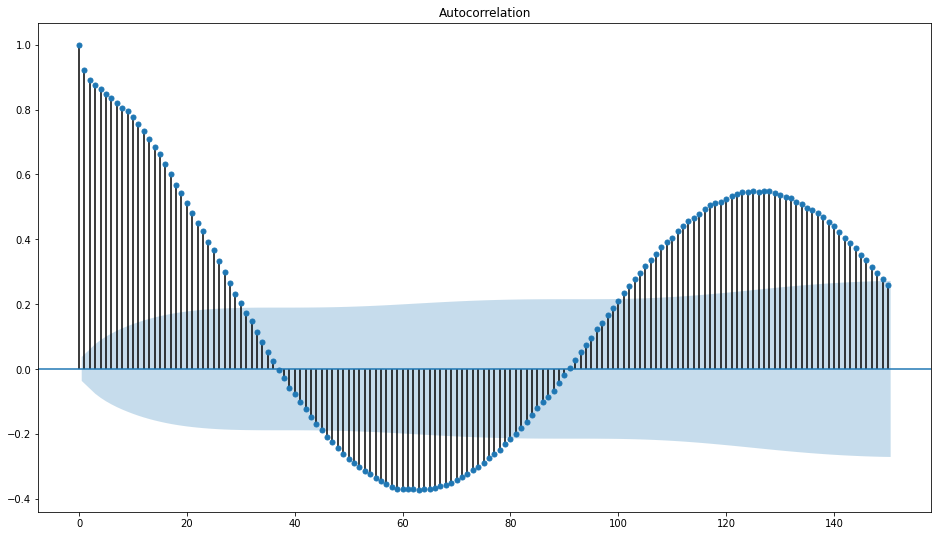

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from pylab import rcParams
rcParams["figure.figsize"] = 16, 9

series = df.set_index("Month")
fig = plot_acf(series, lags=150)